In [1]:
import boto3
import awswrangler as wr
import pandas as pd
from tqdm import tqdm
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

In [2]:
data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]
sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)
df_dict = {}
for source in data_sources:
	dfs = []
	print(source)
	for path in tqdm(sources_dict[source]):
		new_df = wr.s3.read_parquet(path, boto3_session=session)
		new_df["date"] = path.split("/")[-1].split(".")[0]
		dfs.append(new_df)

	df_dict[source] = pd.concat(dfs, axis = 0)
joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
joined_df.shape

seekingAlpha.seekingAlphaBulkMetrics


  0%|          | 0/32 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_94938/716229386.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
  3%|▎         | 1/32 [00:01<00:33,  1.08s/it]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_94938/716229386.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
  6%|▋         | 2/32 [00:03<00:47,  1.59s/it]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T

gurufocus


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


(50439, 339)

In [3]:
all_dates = joined_df.index.get_level_values(0).unique().sort_values().values
all_dates[:5]

array(['2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03',
       '2023-10-04'], dtype=object)

In [4]:
joined_df.loc["2023-09-28"]

,altman_z_score,analysts_down,analysts_down_percent,analysts_down_percent_avg_5y,analysts_up,analysts_up_percent,analysts_up_percent_avg_5y,assets_turnover,assets_turnover_avg_5y,authors_count,...,area,Price-to-DCF__Earnings_Based_,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO,Volume,Avg_Volume__2M_,Market_Cap,Enterprise_Value
ticker,,,,,,,,,,,,,,,,,,,,,
A,6.153144,15.0,100.000000,12.759212,0.0,0.000000,87.240790,0.661089,0.601508,4.0,...,Medical Diagnostics & Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,1.401235,7.0,100.000000,60.404625,0.0,0.000000,39.595375,0.728491,0.757975,2.0,...,Metals & Mining,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,0.862385,9.0,52.941177,53.991806,8.0,47.058823,46.008194,0.782322,0.599356,7.0,...,Transportation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAP,2.266178,15.0,100.000000,39.274876,0.0,0.000000,60.725124,0.917976,0.929945,8.0,...,Retail - Cyclical,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,7.639575,8.0,22.222221,23.935060,28.0,77.777780,76.064940,1.143769,0.929182,36.0,...,Hardware,1.29,1.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZS,4.317831,4.0,12.121212,16.110676,29.0,87.878784,83.889320,0.502082,0.491221,10.0,...,Software,NaN,NaN,3018.4,NaN,NaN,NaN,NaN,NaN,NaN
ZTO,4.868613,2.0,18.181818,50.492565,9.0,81.818184,49.507435,0.498667,0.510452,1.0,...,Transportation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTS,7.658604,1.0,9.090909,28.892622,10.0,90.909090,71.107376,0.597550,0.566861,3.0,...,Drug Manufacturers,1.17,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
overlap_tickers = set(joined_df.index.get_level_values(1).tolist())

for d in tqdm(all_dates):
	day_df = joined_df.loc[d]
	overlap_tickers = overlap_tickers.intersection(set(day_df.index.tolist()))
	print(len(overlap_tickers))

len(overlap_tickers)

100%|██████████| 32/32 [00:00<00:00, 940.02it/s]

1570
1553
1543
1538
1531
1529
1523
1518
1512
1507
1500
1489
1458
1449
1446
1441
1431
1418
1411
1406
1398
1392
1388
1383
1376
1373
1372
1370
1367
1364
1360
1357


1357

In [5]:
filtered_df = joined_df[joined_df.index.get_level_values(1).isin(overlap_tickers)]
filtered_df.shape

(43424, 339)

In [6]:
day_df_0 = filtered_df.loc["2023-10-02"].select_dtypes(float)

In [7]:
corr_cols = []

for d in all_dates[2:]:
	day_df = filtered_df.loc[d].select_dtypes(float)
	cols = day_df_0.corrwith(day_df)
	corr_cols.append(cols)

Text(0, 0.5, 'Pearson')

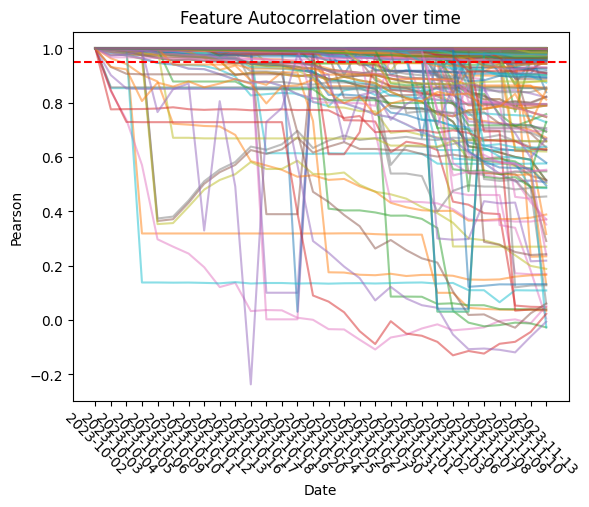

In [12]:
import matplotlib.pyplot as plt
corr_df = pd.DataFrame(corr_cols)
corr_df.plot(legend=None, alpha = 0.5)
plt.axhline(y = .95, color = "r", linestyle = "dashed")
plt.title("Feature Autocorrelation over time")
plt.xticks(ticks = [i for i in range(len(all_dates[2:]))], labels = all_dates[2:], rotation = -45)
plt.xlabel("Date")
plt.ylabel("Pearson")

In [61]:
corr_df

,altman_z_score,analysts_down,analysts_down_percent,analysts_down_percent_avg_5y,analysts_up,analysts_up_percent,analysts_up_percent_avg_5y,assets_turnover,assets_turnover_avg_5y,authors_count,...,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO,Volume,Avg_Volume__2M_,Market_Cap,Enterprise_Value,FCF_Margin_%,FCF_Yield_%
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1,1.000000,0.998492,0.996187,0.999996,0.999269,0.996187,0.999996,1.000000,1.000000,0.997953,...,0.999704,0.999824,0.999834,0.999722,0.931402,0.999793,0.999939,0.999898,NaN,NaN
2,1.000000,0.997415,0.991889,0.999985,0.998339,0.991889,0.999985,1.000000,1.000000,0.978711,...,0.999683,0.999905,0.999781,0.999397,0.922635,0.999770,0.999923,0.999913,NaN,NaN
3,0.999999,0.991398,0.991080,0.999966,0.997870,0.991080,0.999966,0.999977,1.000000,0.961980,...,0.999437,0.999911,0.999693,0.998943,0.806094,0.998432,0.999896,0.999828,NaN,NaN
4,0.999998,0.989126,0.990391,0.999951,0.996707,0.990391,0.999951,0.999971,0.999999,0.946389,...,0.999465,0.999916,0.999877,0.998987,0.873995,0.998155,0.999861,0.999781,NaN,NaN
5,0.999998,0.986323,0.975267,0.999905,0.994560,0.975267,0.999905,0.999971,0.999999,0.939710,...,0.999464,0.999770,0.999743,0.999217,0.859298,0.997236,0.999841,0.999669,NaN,NaN
6,0.999998,0.985114,0.972949,0.999864,0.993890,0.972949,0.999864,0.999971,0.999998,0.938365,...,0.999362,0.999719,0.999542,0.999665,0.878213,0.996865,0.999880,0.999660,NaN,NaN
7,0.999998,0.983531,0.971948,0.999814,0.992935,0.971948,0.999814,0.999970,0.999997,0.935563,...,0.999017,0.999663,0.999386,0.999173,0.856589,0.995040,0.999572,0.999650,NaN,NaN
8,0.999994,0.980571,0.966468,0.999758,0.991398,0.966468,0.999758,0.999970,0.999997,0.921451,...,0.998190,0.999694,0.999230,0.999477,0.870493,0.994798,0.999724,0.999452,NaN,NaN
9,0.999986,0.978717,0.963176,0.999721,0.989619,0.963176,0.999721,0.999961,0.999996,0.896240,...,0.997928,0.999485,0.998402,0.999504,0.887690,0.994334,0.999747,0.999439,NaN,NaN


In [70]:
long_term_columns = corr_df.columns[(corr_df.loc[0:5].min() > 0.99)]
short_term_columns = corr_df.columns[(corr_df.loc[0:5].min() <= 0.99)]

In [71]:
len(short_term_columns)

42

In [72]:
short_term_columns

Index(['analysts_down', 'analysts_down_percent', 'analysts_up_percent',
       'authors_count', 'capm_alpha_60m', 'coefficient_of_variation_90d',
       'debt_eq', 'div_growth_category', 'div_safety_category',
       'dividends_estimate_fy1_analyst_down',
       'dividends_estimate_fy1_analyst_up',
       'dividends_estimate_fy2_analyst_down',
       'dividends_estimate_fy2_analyst_up',
       'dps_consensus_mean_percent_revisions_down_1_annual_period_fwd',
       'eps_ltg', 'last_price_vs_sma_100d', 'last_price_vs_sma_10d',
       'last_price_vs_sma_200d', 'last_price_vs_sma_50d', 'momentum_12m',
       'momentum_3m', 'momentum_6m', 'momentum_9m', 'pb_ratio',
       'price_return_1y', 'price_return_3m', 'price_return_6m',
       'price_return_9m', 'return_on_net_tangible_assets',
       'return_on_total_capital', 'Future_3-5Y_EPS_without_NRI_Growth_Rate',
       'moment_rank', '5-Day_RSI', '9-Day_RSI', '14-Day_RSI',
       '6-1_Month_Momentum_%', '12-1_Month_Momentum_%', 'ratios_rank'

In [73]:
len(long_term_columns)

293

In [74]:
filtered_df.index.get_level_values(0).unique().sort_values()

Index(['2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03', '2023-10-04',
       '2023-10-05', '2023-10-06', '2023-10-09', '2023-10-10', '2023-10-11',
       '2023-10-12', '2023-10-13', '2023-10-16', '2023-10-17', '2023-10-18',
       '2023-10-19', '2023-10-20', '2023-10-24', '2023-10-25', '2023-10-26',
       '2023-10-27', '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
       '2023-11-03', '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
       '2023-11-10', '2023-11-13'],
      dtype='object', name='date')

In [75]:
def create_autoreg_features(df, short_term_features, num_days = 2):
	all_days = df.index.get_level_values(0).unique().sort_values()

	new_df = pd.DataFrame()
	for dayIndex in range(num_days, all_days.shape[0]):
		day = all_days[dayIndex]

		newDayDf = df.loc[day]
		newDayDf["date"] = day
		currTickers = newDayDf.index.values
		for prevIndex in range(num_days):
			prevDay = all_days[dayIndex - prevIndex]
			prevDayFeatures = df.loc[prevDay].reindex(currTickers)[short_term_features].add_suffix(f"_prev_{prevIndex + 1}")
			newDayDf = pd.concat([newDayDf, prevDayFeatures], axis = 1)
		
		new_df = pd.concat([new_df, newDayDf.set_index("date", append = True)], axis = 0)
	
	return new_df

In [76]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

num_days = 2

autoreg_df = create_autoreg_features(filtered_df, short_term_columns, num_days = num_days)

In [77]:
autoreg_removed_rows = filtered_df.loc[all_dates[:num_days]].shape[0]

assert filtered_df.shape[0] - autoreg_df.shape[0] == autoreg_removed_rows, "Autoregression removed different amount of rows than expected"

In [78]:
filtered_df.isna().sum().sum()

3265336

In [79]:
autoreg_df.isna().sum().sum()

3320847

In [80]:
autoreg_df = autoreg_df.reorder_levels([1, 0])

In [81]:
# Auto-regressive data is created!

autoreg_df.head()

altman_z_score  analysts_down  analysts_down_percent  \
date       ticker                                                         
2023-10-02 A             6.153144           15.0             100.000000   
           AA            1.401235            7.0             100.000000   
           AAL           0.862385           10.0              55.555557   
           AAP           2.266178           16.0             100.000000   
           AAPL          7.639575            8.0              22.222221   

                   analysts_down_percent_avg_5y  analysts_up  \
date       ticker                                              
2023-10-02 A                          12.918956          0.0   
           AA                         60.447120          0.0   
           AAL                        54.070970          8.0   
           AAP                        39.409720          0.0   
           AAPL                       23.970476         28.0   

                   analysts_up_percent  analysts_up_percent_avg_5y  \
date       ticker                                                    
2023-10-02 A                  0.000000                   87.081050   
           AA                 0.000000                   39.552880   
           AAL               44.444443                   45.929030   
           AAP                0.000000                   60.590280   
           AAPL              77.777780                   76.029526   

                   assets_turnover  assets_turnover_avg_5y  authors_count  \
date       ticker                                                           
2023-10-02 A              0.661089                0.601639            4.0   
           AA             0.728491                0.757874            2.0   
           AAL            0.782322                0.599261            7.0   
           AAP            0.917976                0.929669            8.0   
           AAPL           1.143769                0.929862           37.0   

                   ...  5-Day_RSI_prev_2  9-Day_RSI_prev_2  14-Day_RSI_prev_2  \
date       ticker  ...                                                          
2023-10-02 A       ...             50.55             42.31              39.95   
           AA      ...             56.29             49.68              46.80   
           AAL     ...             44.24             32.39              28.96   
           AAP     ...             22.80             26.99              29.98   
           AAPL    ...             28.04             33.67              37.01   

                   6-1_Month_Momentum_%_prev_2  12-1_Month_Momentum_%_prev_2  \
date       ticker                                                              
2023-10-02 A                             -9.58                         -3.07   
           AA                           -29.73                        -19.16   
           AAL                            5.36                         15.53   
           AAP                          -43.30                        -59.82   
           AAPL                          14.30                         20.25   

                   ratios_rank_prev_2  Forward_PE_Ratio_prev_2  \
date       ticker                                                
2023-10-02 A                      0.9                    19.30   
           AA                     1.0                    10.73   
           AAL                    1.0                     3.85   
           AAP                    0.2                     9.92   
           AAPL                   0.5                    25.78   

                   EV-to-Forward-EBITDA_prev_2  \
date       ticker                                
2023-10-02 A                             17.56   
           AA                             3.35   
           AAL                            5.18   
           AAP                            8.43   
           AAPL                          20.10   

                   Earnings_Yield__Greenblatt__%_prev_2  Volume_prev_2

In [82]:
autoreg_df.shape

(40710, 423)